## Introduction
CanEx gave me the opportunity to showcase my capabilities, technical depth, problem-solving skills and ability to work with real-world/ambiguous problems. The problem I chose (which I think is the hardest) is the Multiple Pipe Segment Detection (TAP). This problem seems to be harder since it implies spatial locality and is more ambiguous to detect even to the naked eye (e.g less contrast, saturation and brightness). 

### Preliminary analysis
I inspected manually all the given videos in order to familiarize myself with the dataset. First thing I noticed is that the scene is not complex; not so much variance in the colorimetric domain and also not a lot of objects or parallax. That being said, I noticed that the forward movement of the robot can sometimes trouble the water in front of it which can obstruct the lens and make the scene ambiguous. I also noticed TAP on both side that are very close to each other. The roof of the tap is sometime blacken probably due to reparations. Furthermore, the pipe segments seem to always be a bit higher than the ground; this suggests it could be a good idea to focus on the upper part of the video input . I also noticed that the video does not contain a lot of TAP examples. This suggests that it will be required to augment the dataset by doing geometric transformations, applying gaussian noise and other techniques. 

### Game plan
Since I do not have a lot of time to do this work (I am working during the day 😂), I must take a couple of shortcuts.  First, I decided to work with the .mp4 files (i.e GS010016.mp4 and GS010012.mp4). The idea is to have the most training examples in a familiar format easy to work with tooling like ffmpeg and Opencv. I decided to crop the image and focus on the upper part of the front camera (water spills probably add noise). I decided to not edit the video and keep the beginnings and the ending to maintain  the authenticity of the training set and prevent overfitting for future usage. From there, we will build a simple video pipeline to reduce the resolution and switch to the gray scale domain. We’ll also reduce the resolution of the image (~56x24) since the scene seems simple enough. This will help train a cNN on a laptop or even a RPi. In order to showcase my comprehension of how neural nets works, I decided to re-implement [AlexNet](https://en.wikipedia.org/wiki/AlexNet) using Pytorch by adapting the work of [Ben Trevett](https://colab.research.google.com/github/bentrevett/pytorch-image-classification/blob/master/3_alexnet.ipynb#scrollTo=WGjesEGDXVpV&uniqifier=2). Consider this as an homage to Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton who are now freaking out about AGI. A custom Pytorch dataloader will be required to iterate efficiently over the dataset. Since AlexNet uses a supervised approach for discrete image classification (using a cross-entropy loss function); I will use LabelStudio to rapidly annotate all the frames in the original videos with three classes; NO_TAP, LEFT_TAP, RIGH_TAP. This three class problem will be a tradeoff between solving underlying segmentation/edge-detection problem and extract spatial informations. Finally we'll break down the video into frames and map their paths to their corresponding labels in a CSV file. A simple training loop will be run and we'll plot the learning against a validation set with basic accuracy metrics.

### NOTE: As mentionned in the README, to make the final part of the notebook work on the full dataset (or full pipeline.py), simply drop GS010016.mp4 and GS010012.mp4 in the `data/raw` folder.


In [2]:
# Constants
from pathlib import Path
from src import const
import logging

logger = logging.getLogger("exploration_notebook")

DATA_DIR = const.PROJECT_ROOT_DIR / "test" / "data"
RAW_DATA_DIR = DATA_DIR
CLEAN_DATA_DIR = DATA_DIR
NORMALIZED_DATA_DIR = DATA_DIR
FRAME_DIR = DATA_DIR / "frames"
RAW_TEST_VIDEO = [(Path(RAW_DATA_DIR / "sampled.mp4"))]
CLEAN_VIDEO = CLEAN_DATA_DIR / "clean.mp4"
ANNOTATIONS_TEST = DATA_DIR / "annotations.json"

## Raw to clean processing
I selected the original video GS010012.mp4 and GS010012.mp4 for their similarity, lenght and variety of textures. In order to build a rich dataset for training a model, I will first crop and concatenate those two sequences. The cropping focus on the upper scene of the image. since water and spills does not seems to add information for the current detection task. I also find the back camera to be cumbersome for a fast development P.O.C.

In [7]:
from src import pre_processors as ppr
from src import utils

# Clean layer
concat_vid = ppr.concat_videos(RAW_TEST_VIDEO, CLEAN_DATA_DIR / "concat.mp4")
cropped_vid = ppr.crop_video(
    input_path=concat_vid,
    output_path=CLEAN_DATA_DIR / "cropped.mp4",
    crop_x=750,
    crop_y=200,
    crop_w=1400,
    crop_h=750,
)

ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 13.3.0 (conda-forge gcc 13.3.0-2)
  configuration: --prefix=/home/jffontaine/miniconda3/envs/CanExClasif --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1748704128358/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1748704128358/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1748704128358/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1748704128358/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --disable-gnutls --enable-libvpx --enable-libass --enable-pthreads --enable-alsa --enable-libpulse --enable-vaapi --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --en

### Visualizing Raw to clean processing

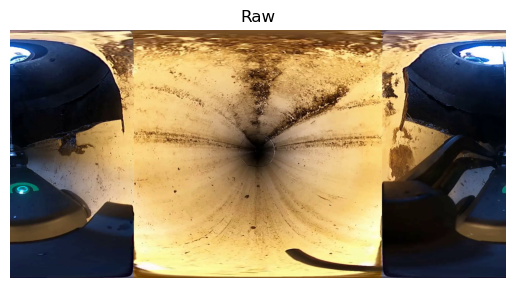

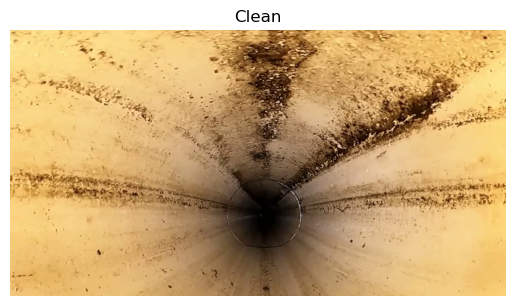

In [8]:
utils.show_first_frame(RAW_TEST_VIDEO[0], title="Raw")
utils.show_first_frame(cropped_vid, title="Clean")

## Clean to normalized
The second layer of our pipeline will change the video frame rate to 10 fps and lower the resolution to 320x180. Thus will help to make the dataset more managable while keeping meaningfull information. This will enable us to train models with low computational ressources. This choice is justify by the assumption that 360/HD video format is not required for the current task.

In [9]:
# fps_reduced_vid = ppr.reduce_fps(input_path=cropped_vid, output_path=NORMALIZED_DATA_DIR / "fps_reduced_vid.mp4", target_fps=25)
grayscale_vid = ppr.to_grayscale(
    input_path=cropped_vid, output_path=NORMALIZED_DATA_DIR / "grayscale_vid.mp4"
)
resized_vid = ppr.reduce_resolution(
    input_path=grayscale_vid,
    output_path=NORMALIZED_DATA_DIR / "resized_vid.mp4",
    width=56,
    height=24,
)

### Visualizing clean to normalized pre-processing

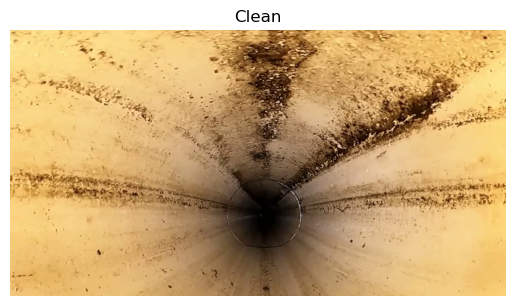

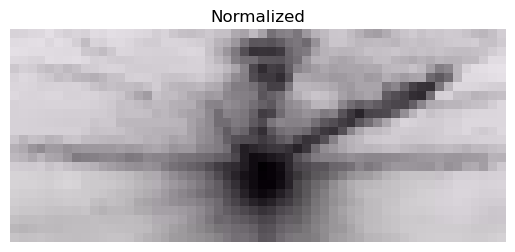

In [10]:
utils.show_first_frame(cropped_vid, title="Clean")
utils.show_first_frame(resized_vid, title="Normalized")

## Normalized to curated processing
In order to train a model in a supervised manner, we will use LabelStudio to label each frame of the video in 3 classes: no_tap, left_tap, right_tap (0, 1, 2). Then we will break down the resulting video from the previous step into frames and associate their path to the corresponding label. This will give us the ability to write a Pytorch dataloader that will feed our neural network. 

In [11]:
import src.pre_processors as ppr
import src.annotations as ann

frames_paths = ppr.extract_frames(resized_vid, FRAME_DIR)
pd_annontations, csv_path = ann.generate_annotations_csv(ANNOTATIONS_TEST, FRAME_DIR)
pd_annontations.head()

File /home/jffontaine/Desktop/canExClassif/test/data/frames/README.md is not a PNG image, skipping.


,path,label
0,/home/jffontaine/Desktop/canExClassif/test/dat...,2
1,/home/jffontaine/Desktop/canExClassif/test/dat...,2
2,/home/jffontaine/Desktop/canExClassif/test/dat...,0
3,/home/jffontaine/Desktop/canExClassif/test/dat...,2
4,/home/jffontaine/Desktop/canExClassif/test/dat...,2


## Inspecting class distribution
Inspecting the classes distribution raise an important issue. Indeed, there is a big imbalance in our training set. This will certainly leed to really good performance while training/testing the model caused by overfitting the NO_TAP class. It will be **imperative** to augment the TAP_LEFT and TAP_RIGHT training examples artificially with geometric transformations and noise addition using OpenCV. For the moment, we will go ahead and continue finishing the pipeline to get an end-to-end P.O.C.

<bound method NDFrame.head of label
0    36668
2      476
1      265
Name: count, dtype: int64>


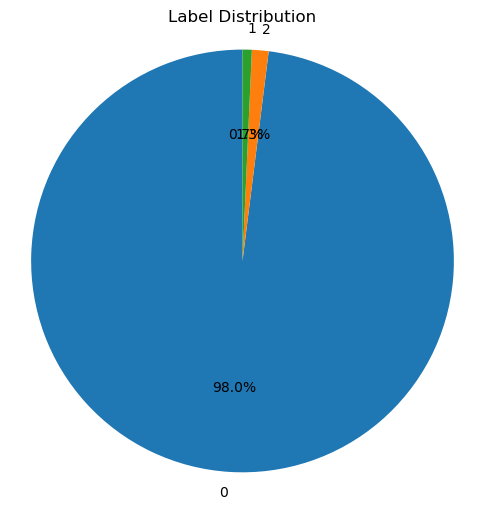

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

full_annotations = pd.read_csv(const.CURATED_DATA_DIR / "annotations.csv")
label_counts = full_annotations[const.LABEL_COL].value_counts()
print(label_counts.head)
# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Label Distribution")
plt.axis("equal")  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

## Training the model on complete dataset

StiWe'll now run our training loop on our AlexNet implementation using an adam optimizer with default learning rate of 0.001. We'll user mini-batching of 64 frames with 10 epochs. Since we are solving a multiclass discrete image classification problem we will use a cross entropy loss functions and evaluate it with simples yet efficient evaluation metrics as described below:

$$
\text{Training Accuracy} = \frac{\sum_{b=1}^{B} \text{Correct}_b}{\sum_{b=1}^{B} \text{Total}_b}
$$


\begin{cases}
\text{Correct}_b & = \text{number of correct predictions in batch } b \\
\text{Total}_b & = \text{total number of samples in batch } b
\end{cases}

$$
\text{Training Loss} = \frac{1}{B} \sum_{b=1}^{B} \text{Loss}_b
$$


\begin{cases}
B & = \text{number of batches (i.e., } \texttt{len(iterator)} \text{)} \\
\text{Loss}_b & = \text{loss computed on batch } b
\end{cases}


In [ ]:
from src import pipeline

results = pipeline.run_full_pipeline()

Training: 100%|██████████| 176/176 [00:50<00:00,  5.26it/s]
                                                           
Epochs:  20%|██        | 1/5 [00:56<03:46, 56.58s/it]        

Epoch: 01 | Epoch Time: 0m 56s
	Train Loss: 0.159 | Train Acc: 97.79%
	 Val. Loss: 0.081 |  Val. Acc: 97.93%



Training: 100%|██████████| 176/176 [00:46<00:00,  5.52it/s]
                                                           
Epochs:  40%|████      | 2/5 [01:49<02:43, 54.64s/it]        

Epoch: 02 | Epoch Time: 0m 53s
	Train Loss: 0.087 | Train Acc: 98.23%
	 Val. Loss: 0.071 |  Val. Acc: 98.48%



Training: 100%|██████████| 176/176 [01:08<00:00,  2.53it/s]
                                                           
Evaluating:   0%|          | 0/117 [00:00<?, ?it/s]

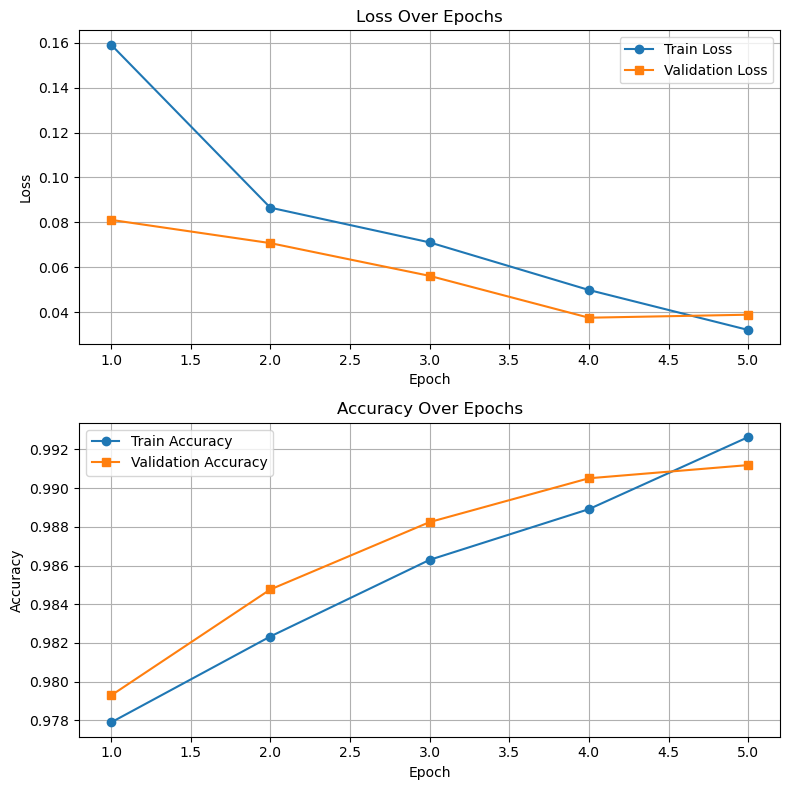

In [17]:
import json
import matplotlib.pyplot as plt


def plot_training_results(file_path):
    # Load data from the JSON file
    with open(file_path, "r") as f:
        data = json.load(f)

    # Extract metrics
    train_loss = data["train_loss"]
    valid_loss = data["valid_loss"]
    train_acc = data["train_acc"]
    valid_acc = data["valid_acc"]
    epochs = list(range(1, len(train_loss) + 1))

    # Create subplots: one for loss, one for accuracy
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))

    # Plot Loss
    axs[0].plot(epochs, train_loss, label="Train Loss", marker="o")
    axs[0].plot(epochs, valid_loss, label="Validation Loss", marker="s")
    axs[0].set_title("Loss Over Epochs")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid(True)

    # Plot Accuracy
    axs[1].plot(epochs, train_acc, label="Train Accuracy", marker="o")
    axs[1].plot(epochs, valid_acc, label="Validation Accuracy", marker="s")
    axs[1].set_title("Accuracy Over Epochs")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid(True)

    # Layout and show
    plt.tight_layout()
    plt.show()


plot_training_results(const.PROJECT_ROOT_DIR / "src" / "result.json")

## Conclusion

While its obvious that the class distribution is bad, the model is still learning very quickly on a very low ressource hardware (laptop cpu). The next step would be to do data augmentation and also reducing the number of NO_TAP sample in our dataset. I will consider this P.O.C done for the sake of time allowed to do it. 


## Further improvements
- Augment LEFT_TAP/RIGHT_PATH training example and reducing NO_TAP example: use the result of a K-mean training protocol to get more realistic results.
- Create a confusion matrix or use classification_report from scikit to better understand model mistake
- Embeded image frames via a pre-trained model and visualize these vectors with a PCA to better understand the natural distribution of classes
- Make a data loader that fetch from one drive (or other provider)
- Include MyPy